In [182]:
import numpy as np
from scipy.linalg import cholesky, eigvals
import random
import pandas as pd
import matplotlib.pyplot as plt
import time

Problem 1

Use the stock returns in DailyReturn.csv for this problem. DailyReturn.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.

Create a routine for calculating an exponentially weighted covariance matrix. If you have a package that calculates it for you, verify that it calculates the values you expect. This means you still have to implement it.

Vary λ ∈ (0, 1). Use PCA and plot the cumulative variance explained by each eigenvalue for each λchosen.
What does this tell us about values of λ and the effect it has on the covariance matrix?

Problem 1.1

Create a routine for calculating an exponentially weighted covariance matrix. If you have a package that calculates it for you, verify that it calculates the values you expect. This means you still have to implement it.

In [7]:
df = pd.read_csv("DailyReturn.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
def exp_weighted_cov(input, lambda_=0.97):
    ror = input.values
    ror_mean = np.mean(ror, axis=0)
    dev = ror - ror_mean
    times = dev.shape[0]
    weights = np.zeros(times)
    
    for i in range(times):
        weights[times - i - 1]  = (1 - lambda_) * lambda_**i
    
    weights_mat = np.diag(weights/sum(weights))

    cov = np.transpose(dev) @ weights_mat @ dev
    return cov

In [207]:
exp_weighted_cov_mat = exp_weighted_cov(df)

Problem 1.2

Vary λ ∈ (0, 1). Use PCA and plot the cumulative variance explained by each eigenvalue for each λchosen.

In [25]:
def simulate_pca(a, nsim, nval=None):
    # Eigenvalue decomposition
    vals, vecs = np.linalg.eig(a)

    # Sort the eigenvalues and corresponding eigenvectors in descending order
    idx = np.argsort(-vals)
    vals = vals[idx]
    vecs = vecs[:, idx]

    posv = np.where(vals >= 1e-8)[0]
    if nval is not None:
        if nval < len(posv):
            posv = posv[:nval]
    vals = vals[posv]
    vecs = vecs[:, posv]

    cum_var = (np.cumsum(vals[:nsim]) / np.sum(vals))[-1]

    return cum_var

In [29]:
lambdas = [0.1, 0.4, 0.6, 0.9, 0.97]
cum_vars = []

for l in lambdas:
    this_cov = exp_weighted_cov(df, l)
    this_cum_vars = []
    for i in range(1, 100):
        this_cum_vars.append(simulate_pca(this_cov, i))
    cum_vars.append(this_cum_vars)


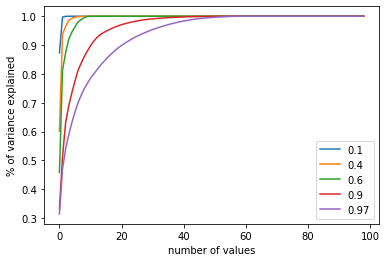

In [211]:
plt.figure()
for i in cum_vars:
    plt.plot(i)

plt.legend(lambdas)
plt.xlabel('number of values')
plt.ylabel('% of variance explained')
plt.show()

Problem 2

Copy the chol_psd(), and near_psd() functions from the course repository – implement in your programming language of choice. These are core functions you will need throughout the remainder of the class.

Implement Higham’s 2002 nearest psd correlation function.

Generate a non-psd correlation matrix that is 500x500. You can use the code I used in class:
n=500
sigma = fill(0.9,(n,n))
for i in 1:n
    sigma[i,i]=1.0
end
sigma[1,2] = 0.7357
sigma[2,1] = 0.7357

Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.

Compare the results of both using the Frobenius Norm. Compare the run time between the two. How does the run time of each function compare as N increases?

Based on the above, discuss the pros and cons of each method and when you would use each. There is no wrong answer here, I want you to think through this and tell me what you think.

Problem 2.1

Copy the chol_psd(), and near_psd() functions from the course repository – implement in your programming language of choice. These are core functions you will need throughout the remainder of the class.

In [30]:
#Cholesky that assumes PSD
def chol_psd(a):
    n = a.shape[0]
    root = np.zeros((n, n))

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])
        temp = a[j, j] - s
        if temp <= 0:
            temp = 0.0
        root[j, j] = np.sqrt(temp)

        if root[j, j] == 0.0:
            root[j, j+1:] = 0.0
        else:
            ir = 1.0 / root[j, j]
            for i in range(j + 1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (a[i, j] - s) * ir
    return root

In [173]:
#Near PSD Matrix
def near_psd(a, epsilon=0.0):
    n = a.shape[0]

    invSD = None
    out = a.copy()

    # calculate the correlation matrix if we got a covariance
    if np.count_nonzero(np.diag(out) == 1.0) != n:
        invSD = np.diag(1 / np.sqrt(np.diag(out)))
        out = np.matmul(np.matmul(invSD, out), invSD)

    # SVD, update the eigen value and scale
    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = np.reciprocal(np.matmul(np.square(vecs), vals))
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    out = B @ B.T

    #Add back the variance
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        out = invSD @ out @ invSD
    return out

Problem 2.2

Implement Higham’s 2002 nearest psd correlation function.

In [185]:
def Frobenius(input):
    result = 0
    for i in range(len(input)):
        for j in range(len(input)):
            result += input[i][j]**2
    return result

In [186]:
def Higham_psd(input):
    weight = np.identity(len(input))
        
    norml = np.inf
    Yk = input.copy()
    Delta_S = np.zeros_like(Yk)
    
    invSD = None
    if np.count_nonzero(np.diag(Yk) == 1.0) != input.shape[0]:
        invSD = np.diag(1 / np.sqrt(np.diag(Yk)))
        Yk = invSD @ Yk @ invSD
    
    Y0 = Yk.copy()

    for i in range(1000):
        Rk = Yk - Delta_S
        # PS
        Xk = np.sqrt(weight)@ Rk @np.sqrt(weight)
        vals, vecs = np.linalg.eigh(Xk)
        vals = np.where(vals > 0, vals, 0)
        Xk = np.sqrt(weight)@ vecs @ np.diagflat(vals) @ vecs.T @ np.sqrt(weight)
        Delta_S = Xk - Rk
        #PU
        Yk = Xk.copy()
        np.fill_diagonal(Yk, 1)
        norm = Frobenius(Yk-Y0)
        #norm = np.linalg.norm(Yk-Y0, ord='fro')
        min_val = np.real(np.linalg.eigvals(Yk)).min()
        if abs(norm - norml) < 1e-8 and min_val > -1e-9:
            break
        else:
            norml = norm
    
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        Yk = invSD @ Yk @ invSD
    return Yk

Problem 2.3

Generate a non-psd correlation matrix that is 500x500. You can use the code I used in class:
n=500
sigma = fill(0.9,(n,n))
for i in 1:n
    sigma[i,i]=1.0
end
sigma[1,2] = 0.7357
sigma[2,1] = 0.7357

In [187]:
n = 500
sigma = np.full((n,n),0.9)
for i in range(n):
    sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

Problem 2.4

Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.

In [176]:
def is_psd(matrix):
    vals = np.linalg.eigh(matrix)[0]
    return np.all(vals >= -1e-8)

In [188]:
print("Sigma: ", is_psd(sigma))
print("Sigma fixed with near_psd(): ", is_psd(near_psd(sigma)))
print("Sigma fixed with Higham_psd(): ", is_psd(Higham_psd(sigma)))

Sigma:  False
Sigma fixed with near_psd():  True
Sigma fixed with Higham_psd():  True


Problem 2.5

Compare the results of both using the Frobenius Norm.


/var/folders/mx/h47vz6_d3cj1b2c96lcwngfh0000gn/T/ipykernel_33783/1022536968.py:16: RuntimeWarning: invalid value encountered in reciprocal
  T = np.reciprocal(np.matmul(np.square(vecs), vals))


[0.034479029796030715, 0.07441520643488334, 0.11434167015298123, 0.15426458619636677, 0.19418590463066357, 0.23410637472482018, 0.2740263418613265, 0.3139459866926763, 0.3538654127390431]
[0.006189339355289434, 0.007164374459157218, 0.007517245714743978, 0.0076992888243104796, 0.007810362192229281, 0.007885193678452055, 0.007939032137917149, 0.007979624429548117, 0.008011323402941264]


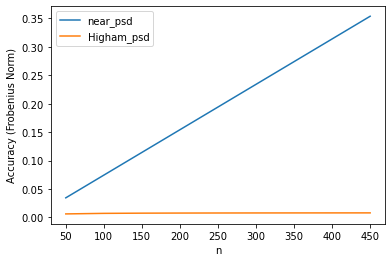

In [212]:
n_range = np.arange(50, 500, 50)
near = []
higham = []
for i in n_range:
    current_sigma = sigma[:i, :i]
    
    near_sigma = near_psd(current_sigma)
    near_frobenius = Frobenius(current_sigma-near_sigma)
    #near_frobenius = np.linalg.norm(current_sigma-near_sigma, ord='fro')
    near.append(near_frobenius)
    
    higham_sigma = Higham_psd(current_sigma)
    higham_frobenius = Frobenius(current_sigma-higham_sigma)
    #higham_frobenius = np.linalg.norm(current_sigma-higham_sigma, ord='fro')
    higham.append(higham_frobenius)

print(near)
print(higham)
    


plt.plot(n_range, near, label='near_psd')
plt.plot(n_range, higham, label='Higham_psd')
plt.legend()
plt.xlabel('n')
plt.ylabel('Accuracy (Frobenius Norm)')
plt.show()

Problem 2.6

Compare the run time between the two. How does the run time of each function compare as N increases?

/var/folders/mx/h47vz6_d3cj1b2c96lcwngfh0000gn/T/ipykernel_33783/1022536968.py:16: RuntimeWarning: invalid value encountered in reciprocal
  T = np.reciprocal(np.matmul(np.square(vecs), vals))


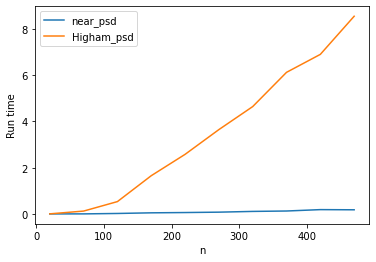

In [184]:
n_range = np.arange(20, 501, 50)
time_near_psd = []
time_higham_psd = []
for n in n_range:
    sigma_current = sigma[:n, :n]
    
    start_time = time.time()
    sigma_fixed_near = near_psd(sigma_current)
    time_near = time.time() - start_time
    time_near_psd.append(time_near)
    
    start_time = time.time()
    sigma_fixed_higham = Higham_psd(sigma_current)
    time_higham = time.time() - start_time
    time_higham_psd.append(time_higham)

plt.plot(n_range, time_near_psd, label='near_psd')
plt.plot(n_range, time_higham_psd, label='Higham_psd')
plt.xlabel('n')
plt.ylabel('Run time')
plt.legend()
plt.show()

Problem 3

Using DailyReturn.csv.

Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained. If you have a library that can do these, you still need to implement it yourself for this homework and prove that it functions as expected.

Generate a correlation matrix and variance vector 2 ways:

1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and
var() functions).

2. Exponentially weighted λ = 0. 97

Combine these to form 4 different covariance matrices. (Pearson correlation + var()), Pearson correlation + EW variance, etc.)

Simulate 25,000 draws from each covariance matrix using:

1. Direct Simulation

2. PCA with 100% explained.

3. PCA with 75% explained.

4. PCA with 50% explained.

Calculate the covariance of the simulated values. Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices).

Compare the run times for each simulation.

What can we say about the trade offs between time to run and accuracy.

Problem 3.1

Using DailyReturn.csv.

Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained. If you have a library that can do these, you still need to implement it yourself for this homework and prove that it functions as expected.


In [197]:
#simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained.
def multivar_norm_simu(cov, method='direct', mean = 0, explained_variance=1.0, samples_num=25000):
    if method == 'direct':
        L = chol_psd(cov)
        normal_samples = np.random.normal(size=(cov.shape[0], samples_num))
        samples = np.transpose(L @ normal_samples + mean)
        return samples
    
    elif method == 'pca':
        vals, vecs = np.linalg.eigh(cov)
        idx = vals > 1e-8
        vals = vals[idx]
        vecs = vecs[:, idx]
        
        idx = np.argsort(vals)[::-1]
        vals = vals[idx]
        vecs = vecs[:, idx]
        
        if explained_variance == 1.0:
            explained_variance = (np.cumsum(vals)/np.sum(vals))[-1]
        
        n_components = np.where((np.cumsum(vals)/np.sum(vals))>= explained_variance)[0][0] + 1
        vecs = vecs[:,:n_components]
        vals = vals[:n_components]

        normal_samples = np.random.normal(size=(n_components, samples_num))
        
        B = vecs @ np.diag(np.sqrt(vals))
        samples = np.transpose(B @ normal_samples)
        
        return samples

Problem 3.2

Generate a correlation matrix and variance vector 2 ways:

1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and
var() functions).

2. Exponentially weighted λ = 0. 97

Combine these to form 4 different covariance matrices. (Pearson correlation + var()), Pearson correlation + EW variance, etc.)

The four combinations are

1. Pearson correlation and var

2. Pearson correlation and EW variance

3. EW(cov+corr)

4. EW Corr +Var

In [191]:
#1. Pearson correlation and var
p_cov_var = np.cov(df, rowvar=False)

In [203]:
#2. Pearson correlation and EW variance
def p_corr_ew_var_f(returns, lambda_=0.97):
    cov = exp_weighted_cov(returns, lambda_)
    std_dev = np.sqrt(np.diag(cov))
    corr = np.corrcoef(returns.T)
    cov = np.outer(std_dev, std_dev) * corr
    return cov
p_corr_ew_var = p_corr_ew_var_f(df)

In [192]:
#3. EW(cov+corr) is exp_weighted_cov(input, lambda_)
ew_corr_cov = exp_weighted_cov(df)

In [193]:
#4. EW Corr +Var
def ew_corr_p_var_f(returns, lambda_=0.97):
    cov = exp_weighted_cov(returns, lambda_)
        
    asset_std = np.diag(np.reciprocal(np.sqrt(np.diag(cov))))
    corr = asset_std @ cov @ asset_std.T
    
    var = np.var(returns)
    std_dev = np.sqrt(var)
    
    cov = np.outer(std_dev, std_dev) * corr
    return cov

ew_corr_p_var = ew_corr_p_var_f(df)

/var/folders/mx/h47vz6_d3cj1b2c96lcwngfh0000gn/T/ipykernel_33783/1176477688.py:5: RuntimeWarning: invalid value encountered in reciprocal
  asset_std = np.diag(np.reciprocal(np.sqrt(np.diag(cov))))


Simulate 25,000 draws from each covariance matrix using:

1. Direct Simulation

2. PCA with 100% explained.

3. PCA with 75% explained.

4. PCA with 50% explained.

Calculate the covariance of the simulated values. Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices).

In [200]:
def time_and_error(covariance_matrix, method, explained_variance=1.0):
    
    start_time = time.time()
    samples = multivar_norm_simu(covariance_matrix, method=method, explained_variance=explained_variance)
    time_used = time.time() - start_time
    
    simulated_covariance = np.cov(samples, rowvar=False)
    error = Frobenius(simulated_covariance - covariance_matrix)
    
    return time_used, error

In [220]:
def simulate4(covariance_matrix):
    np.random.seed(0)
    variances = [1.0, 0.75, 0.5]
    
    time_used = []
    errors = []
    labels = []
    
    t, error = time_and_error(covariance_matrix, 'direct')
    time_used.append(t)
    errors.append(error)
    labels.append("direct")
    
    for var in variances:
        t, error = time_and_error(covariance_matrix, 'pca', var)
        time_used.append(t)
        errors.append(error)
        labels.append("PCA with {}".format(var))
            
    plt.plot(time_used, errors, 'r+')
    
    for i, label in enumerate(labels):
        plt.annotate(label, (time_used[i], errors[i]))
        
    plt.xlabel('Time used')
    plt.ylabel('Accuracy(Frobenius Norm)')

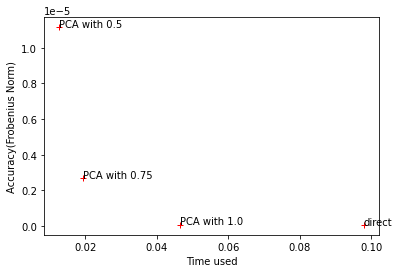

In [221]:
simulate4(p_cov_var)

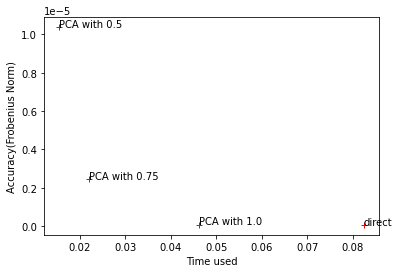

In [222]:
simulate4(p_corr_ew_var)

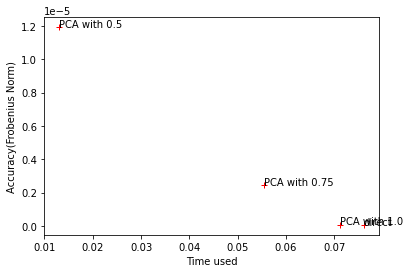

In [223]:
simulate4(ew_corr_cov)

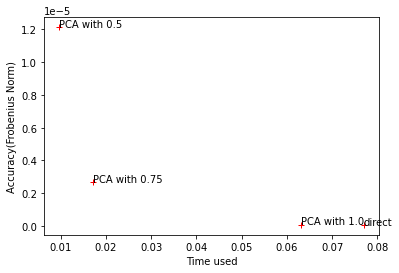

In [224]:
simulate4(ew_corr_p_var)